# Predicting Heart Disease

Link to Competittion: https://www.kaggle.com/competitions/playground-series-s6e2/overview

## Imports

In [32]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import catboost
from catboost import CatBoostRegressor

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, accuracy_score, mean_squared_error, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.tree import plot_tree
from sklearn.compose import ColumnTransformer

from scipy.optimize import minimize

from common import *

In [2]:
from platform import python_version
print('python: ', python_version())
print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
import sklearn
print('sklearn: ', sklearn.__version__)
print('xgboost: ', xgb.__version__)
print('LightGBM: ', lgb.__version__)

python:  3.13.11
pandas:  2.3.3
numpy:  2.3.5
matplotlib:  3.10.8
seaborn:  0.13.2
sklearn:  1.8.0
xgboost:  3.1.3
LightGBM:  4.6.0


## Load data

In [3]:
orig_train_df = pd.read_csv('archive/train.csv')
orig_test_df = pd.read_csv('archive/test.csv')

## Call the pipeline

In [4]:
train_df = (orig_train_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          # .pipe(remove_duplicates)
          .pipe(make_new_features)
          # .pipe(encode_all_the_things)
          # .pipe(fill_nas)
           )

In [5]:
test_df = (orig_test_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          # .pipe(remove_duplicates)
          .pipe(make_new_features)
          # .pipe(encode_all_the_things)
          # .pipe(fill_nas)
           )

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      630000 non-null  int64  
 1   sex                      630000 non-null  int64  
 2   chest_pain_type          630000 non-null  int64  
 3   bp                       630000 non-null  int64  
 4   cholesterol              630000 non-null  int64  
 5   fbs_over_120             630000 non-null  int64  
 6   ekg_results              630000 non-null  int64  
 7   max_hr                   630000 non-null  int64  
 8   exercise_angina          630000 non-null  int64  
 9   st_depression            630000 non-null  float64
 10  slope_of_st              630000 non-null  int64  
 11  number_of_vessels_fluro  630000 non-null  int64  
 12  thallium                 630000 non-null  int64  
 13  heart_disease            630000 non-null  int64  
dtypes: f

## Choose target and features

In [7]:
target = get_target()

In [8]:
features = get_features(train_df)

In [9]:
if 'exam_difficulty' in features:
    features.pop(features.index('exam_difficulty'))

In [9]:
categorical_features = []

In [10]:
numerical_features = [f for f in features if f not in categorical_features]

In [11]:
categorical_features

[]

In [12]:
numerical_features

['age',
 'sex',
 'chest_pain_type',
 'bp',
 'cholesterol',
 'fbs_over_120',
 'ekg_results',
 'max_hr',
 'exercise_angina',
 'st_depression',
 'slope_of_st',
 'number_of_vessels_fluro',
 'thallium']

## Encoding

In [21]:
X_train = train_df[features].copy()
y_train = train_df[target]

X_test = test_df[features].copy()

In [23]:
ct = ColumnTransformer([], remainder='passthrough')

In [24]:
ct.set_output(transform='pandas')
X_train_encoded = ct.fit_transform(X_train)
X_test_encoded = ct.transform(X_test)

### adding featues

In [26]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   remainder__age                      630000 non-null  int64  
 1   remainder__sex                      630000 non-null  int64  
 2   remainder__chest_pain_type          630000 non-null  int64  
 3   remainder__bp                       630000 non-null  int64  
 4   remainder__cholesterol              630000 non-null  int64  
 5   remainder__fbs_over_120             630000 non-null  int64  
 6   remainder__ekg_results              630000 non-null  int64  
 7   remainder__max_hr                   630000 non-null  int64  
 8   remainder__exercise_angina          630000 non-null  int64  
 9   remainder__st_depression            630000 non-null  float64
 10  remainder__slope_of_st              630000 non-null  int64  
 11  remainder__number_of_vesse

## OOF predictions

In [27]:
# Initialize OOF arrays
oof_xgb = np.zeros(len(X_train_encoded))

## CV loop

In [28]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)

In [29]:
# CatBoost doesn't want/need categorical features encoded
X_train_cat = train_df[features].copy()
X_test_cat = test_df[features].copy()

for col in categorical_features:
    X_train_cat[col] = X_train_cat[col].astype('category')
    X_test_cat[col] = X_test_cat[col].astype('category')

In [37]:
xgb_model = XGBClassifier(
    n_estimators=500,
    random_state=123,
    n_jobs=-1
)

In [36]:
# Generate OOF predictions

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_cat)):
    X_tr = X_train_cat.iloc[train_idx].copy()  # copy to avoid SettingWithCopyWarning
    X_val = X_train_cat.iloc[val_idx].copy()
    y_tr = y_train.iloc[train_idx]

    # target encoding
    for col in categorical_features:  # removed brackets
        means = y_tr.groupby(X_tr[col]).mean()
        X_tr[f"{col}_target_enc"] = X_tr[col].map(means).astype('float64')
        X_val[f"{col}_target_enc"] = X_val[col].map(means).astype('float64')
    
    xgb_model.fit(X_tr, y_tr)
    oof_xgb[val_idx] = xgb_model.predict(X_val)
    print(f"Fold {fold+1} complete")

print(f" ROC AUC: {roc_auc_score(y_train, oof_xgb):.5f}")

Fold 1 complete
Fold 2 complete
Fold 3 complete
Fold 4 complete
Fold 5 complete
 ROC AUC: 0.87817


## Save OOF

In [38]:
np.save('./OOF/oof_xgb_native.npy', oof_xgb)
print("saved OOFs")

saved OOFs


## Run Predictions

In [39]:
for col in categorical_features:
    means = y_train.groupby(X_train_cat[col]).mean()
    X_test_cat[f"{col}_target_enc"] = X_test_cat[col].map(means).astype('float64')

# Also target encode training set for final fit
for col in categorical_features:
    means = y_train.groupby(X_train_cat[col]).mean()
    X_train_cat[f"{col}_target_enc"] = X_train_cat[col].map(means).astype('float64')

# Re-fit on ALL data
xgb_model.fit(X_train_cat, y_train)

# Predict on test
final_preds_xgb = xgb_model.predict(X_test_cat)

## Save Predictions

In [40]:
np.save('./OOF/test_preds_xgb_native.npy', final_preds_xgb)
print("saved test predictions")

saved test predictions


## Final model analysis

<Axes: >

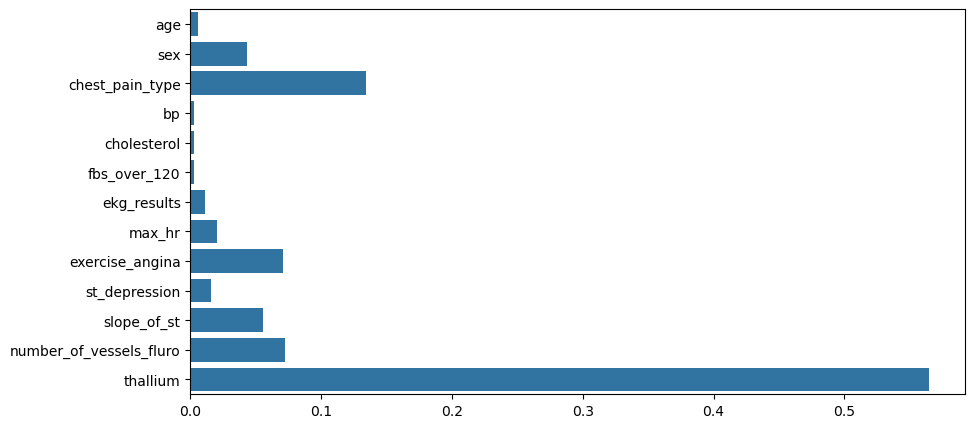

In [41]:
sns.barplot(x=xgb_model.feature_importances_, y=xgb_model.feature_names_in_)

In [42]:
sorted([i for i in zip(xgb_model.feature_importances_, xgb_model.feature_names_in_)], reverse=True)

[(np.float32(0.56431115), np.str_('thallium')),
 (np.float32(0.13401271), np.str_('chest_pain_type')),
 (np.float32(0.07214834), np.str_('number_of_vessels_fluro')),
 (np.float32(0.07063526), np.str_('exercise_angina')),
 (np.float32(0.055105295), np.str_('slope_of_st')),
 (np.float32(0.04316549), np.str_('sex')),
 (np.float32(0.020153716), np.str_('max_hr')),
 (np.float32(0.015488901), np.str_('st_depression')),
 (np.float32(0.011255748), np.str_('ekg_results')),
 (np.float32(0.0057184575), np.str_('age')),
 (np.float32(0.0029009974), np.str_('cholesterol')),
 (np.float32(0.0026608054), np.str_('fbs_over_120')),
 (np.float32(0.0024431704), np.str_('bp'))]